<a href="https://colab.research.google.com/github/Snir5/NLP---Disaster-Tweets-Classification/blob/main/Disaster_Tweets_NLP_Snir_Tahasa.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Participating in the Kaggle challenge by Snir Tahasa

In [2]:
# GPU Access verification
!nvidia-smi

Sun Jan 22 14:44:31 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   56C    P0    29W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# Importing dataset from Kaggle

In [3]:
!ls -lha kaggle.json
!pip install -q kaggle
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 /root/.kaggle/kaggle.json
!pwd

-rw-r--r-- 1 root root 66 Jan 22 14:43 kaggle.json
/content


In [4]:
!kaggle competitions download -c nlp-getting-started

100% 593k/593k [00:00<00:00, 775kB/s]
100% 593k/593k [00:00<00:00, 775kB/s]


In [5]:
# Get helpful functions file from github
import os 

if not os.path.exists("helpful_functions.py"):
    !wget https://raw.githubusercontent.com/Snir5/NLP---Disaster-Tweets-Classification/main/helpful_functions.py
    print("[INFO] 'helpful_functions.py' already exists, skipping download.")

--2023-01-22 14:44:39--  https://raw.githubusercontent.com/Snir5/NLP---Disaster-Tweets-Classification/main/helpful_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10121 (9.9K) [text/plain]
Saving to: ‘helpful_functions.py’

helpful_functions.p 100%[===================>]   9.88K  --.-KB/s    in 0s      

2023-01-22 14:44:39 (100 MB/s) - ‘helpful_functions.py’ saved [10121/10121]

[INFO] 'helpful_functions.py' already exists, skipping download.


In [6]:
import tensorflow as tf
from tensorflow.keras import layers

# Import series of helper functions for the notebook 
from helpful_functions import create_tensorboard_callback, load_and_prep_image, plot_loss_curves, unzip_data, compare_historys, walk_through_dir, make_confusion_matrix, calculate_results

In [7]:
# Unzip data
unzip_data("/content/nlp-getting-started.zip")

# Dataset Investigation

##Visualizing the text dataset

In [8]:
# Read CSV with pandas dataframe
import pandas as pd
train_df = pd.read_csv("train.csv")
test_df = pd.read_csv("test.csv")
train_df.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [9]:
# Shuffle training dataframe
train_df_shuffled = train_df.sample(frac=1, random_state=42) # shuffle with random_state=42
train_df_shuffled.head()

,id,keyword,location,text,target
2644,3796,destruction,NaN,So you have a new weapon that can cause un-ima...,1
2227,3185,deluge,NaN,The f$&amp;@ing things I do for #GISHWHES Just...,0
5448,7769,police,UK,DT @georgegalloway: RT @Galloway4Mayor: ÛÏThe...,1
132,191,aftershock,NaN,Aftershock back to school kick off was great. ...,0
6845,9810,trauma,"Montgomery County, MD",in response to trauma Children of Addicts deve...,0


In [10]:
# Looking at the test data
test_df.head()

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


In [11]:
# How many examples of each class ?
train_df.target.value_counts()

0    4342
1    3271
Name: target, dtype: int64

In [12]:
# How many samples total?
print(f"Total training samples: {len(train_df)}")
print(f"Total test samples: {len(test_df)}")
print(f"Total samples: {len(train_df) + len(test_df)}")

Total training samples: 7613
Total test samples: 3263
Total samples: 10876


In [13]:
# Visualize random training examples
import random
random_index = random.randint(0, len(train_df)-5) # create random indexes not higher than the total number of samples
for row in train_df_shuffled[["text", "target"]][random_index:random_index+5].itertuples():
  _, text, target = row
  print(f"Target: {target}", "(real disaster)" if target > 0 else "(not real disaster)")
  print(f"Text:\n{text}\n")
  print("-------------------------------------------------------------------\n")

Target: 0 (not real disaster)
Text:
@LisaToddSutton The reason I bring this up  bcz he is running 4 Senate. Murphy is nothing but a Republican I am deluged with his junk mail!

-------------------------------------------------------------------

Target: 1 (real disaster)
Text:
When the answer my friend isn't blowing in the wind-IT'S YELLING! -How to Survive a Dust Storm http://t.co/9NwAJLi9cr http://t.co/tKMOtaeaCo

-------------------------------------------------------------------

Target: 0 (not real disaster)
Text:
'13 M. Chapoutier Crozes Hermitage so much purple violets slate crushed gravel white pepper. Yum #france #wine #DC http://t.co/skvWN38HZ7

-------------------------------------------------------------------

Target: 1 (real disaster)
Text:
Aquarium Ornament Wreck Sailing Boat Sunk Ship Destroyer Fish Tank Cave Decor - Full read Û_ http://t.co/nosA8JJjiN http://t.co/WUKvdavUJu

-------------------------------------------------------------------

Target: 1 (real disaster)

# Data preprocessing

##Split data into training and validation sets

In [14]:
from sklearn.model_selection import train_test_split

train_sentences, val_sentences, train_labels, val_labels = train_test_split(train_df_shuffled["text"].to_numpy(),
                                                                            train_df_shuffled["target"].to_numpy(),
                                                                            test_size=0.2, # dedicate 20% of samples to validation set
                                                                            random_state=42)

In [15]:
# Check the lengths
len(train_sentences), len(train_labels), len(val_sentences), len(val_labels)

(6090, 6090, 1523, 1523)

In [16]:
# View the first 10 training sentences and their labels
train_sentences[:10], train_labels[:10]

(array(['Detonation fashionable mountaineering electronic watch water-resistant couples leisure tab\x89Û_ http://t.co/E61x9Y65QD http://t.co/OVLET0gDqm',
        "Men escape car engulfed in flames in Parley's Canyon crews investigating cause - http://t.co/tFan6qq2Ys http://t.co/rAkwWritPo",
        'I-77 Mile Marker 31 to 40 South Mooresville  Iredell Vehicle Accident Congestion at 8/6 1:18 PM',
        "#Greece's tax revenues collapse as debt crisis continues via @guardian #bailout http://t.co/cJvbQXw83s ^mp",
        'Be not afraid of sudden fear neither of the desolation of the wicked when it cometh. For the Lord shall be thy... http://t.co/bP597YDs2b',
        'Storm batters Auckland and Northland: A violent overnight storm has battered Auckland and Northland uprooting... http://t.co/enrPGRgtTs',
        "Benzema increasingly looks to be a casualty of Benitez's new look squad. Arsenal bound? 50-50 chance I think",
        'Acquire your postexistence straight a elevation in addition

##Converting text into numbers

In [17]:
import tensorflow as tf
from tensorflow.keras.layers import TextVectorization

# Use the default TextVectorization variables
text_vectorizer = TextVectorization(max_tokens=None, # how many words in the vocabulary (all of the different words in your text)
                                    standardize="lower_and_strip_punctuation", # how to process text
                                    split="whitespace", # how to split tokens
                                    ngrams=None, # create groups of n-words?
                                    output_mode="int", # how to map tokens to numbers
                                    output_sequence_length=None) # how long should the output sequence of tokens be?
                                    # pad_to_max_tokens=True) # Not valid if using max_tokens=None

In [18]:
# Find average number of tokens (words) in training Tweets
import numpy as np
tweet_lens = [len(tweet.split()) for tweet in train_sentences]
avg_tweet_len = np.mean(tweet_lens)
avg_num_of_tokens = round(avg_tweet_len)
avg_num_of_tokens

15

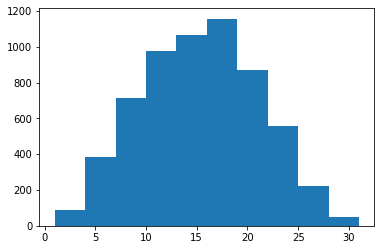

In [19]:
# Plotting the distribution of tokens num
import matplotlib.pyplot as plt
plt.hist((tweet_lens), bins=10);

In [20]:
# How many words of a sentence covers 95% 
output_tweet_len = int(np.percentile(tweet_lens, 95))
output_tweet_len

24

In [21]:
# Setup text vectorization with custom variables
max_vocab_length = 10000 # max number of words to have in our vocabulary
max_length = output_tweet_len # max length our sequences will be (how many words from a Tweet does our model see?)

text_vectorizer = TextVectorization(max_tokens=max_vocab_length,
                                    output_mode="int",
                                    output_sequence_length=max_length)

In [22]:
# Fit the text vectorizer to the training text
text_vectorizer.adapt(train_sentences)

In [23]:
# Create sample sentence and tokenize it
sample_sentence = "There is an earthquake in South East India"
text_vectorizer([sample_sentence])

<tf.Tensor: shape=(1, 24), dtype=int64, numpy=
array([[ 75,   9,  42, 319,   4, 519, 863, 565,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0]])>

In [24]:
# Choose a random sentence from the training dataset and tokenize it
random_sentence = random.choice(train_sentences)
print(f"Original text:\n{random_sentence}\
      \n\nVectorized version:")
text_vectorizer([random_sentence])

Original text:
@fouseyTUBE you ok? Need a ambulance. Hahahah that was good! http://t.co/ZSbErqNN9n      

Vectorized version:


<tf.Tensor: shape=(1, 24), dtype=int64, numpy=
array([[5144,   12,  527,  170,    3,  344, 5059,   16,   23,  136,    1,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0]])>

In [25]:
# Get the unique words in the vocabulary
words_in_vocab = text_vectorizer.get_vocabulary()
top_5_words = words_in_vocab[:5] # most common tokens (notice the [UNK] token for "unknown" words)
bottom_5_words = words_in_vocab[-5:] # least common tokens
print(f"Number of words in vocab: {len(words_in_vocab)}")
print(f"Top 5 most common words: {top_5_words}") 
print(f"Bottom 5 least common words: {bottom_5_words}")

Number of words in vocab: 10000
Top 5 most common words: ['', '[UNK]', 'the', 'a', 'in']
Bottom 5 least common words: ['minded', 'mindblowing', 'milne', 'milledgeville', 'millcityio']


##Creating an Embedding using an Embedding Layer

In [26]:
tf.random.set_seed(42)
from tensorflow.keras import layers

embedding = layers.Embedding(input_dim=max_vocab_length, # set input shape
                             output_dim=512, # set size of embedding vector
                             embeddings_initializer="uniform", # default, intialize randomly
                             input_length=max_length, # how long is each input
                             name="embedding_1") 

embedding

In [27]:
# Get a random sentence from training set
random_sentence = random.choice(train_sentences)
print(f"Original text:\n{random_sentence}\
      \n\nEmbedded version:")

# Embed the random sentence (turn it into numerical representation)
sample_embed = embedding(text_vectorizer([random_sentence]))
sample_embed

Original text:
Families to sue over Legionnaires: More than 40 families affected by the fatal outbreak of Legionnaires' disea... http://t.co/1H7zk6UYze      

Embedded version:


<tf.Tensor: shape=(1, 24, 512), dtype=float32, numpy=
array([[[ 0.02424603, -0.02818347,  0.03436308, ...,  0.03343426,
         -0.01866718, -0.01054706],
        [-0.03769413, -0.00289064, -0.03677417, ..., -0.0175923 ,
         -0.01790538,  0.0255311 ],
        [-0.00897693, -0.0036576 ,  0.02534669, ...,  0.03292612,
         -0.01387886, -0.03199415],
        ...,
        [ 0.01645621, -0.00589932, -0.01471175, ..., -0.01166106,
          0.03061062,  0.01972148],
        [ 0.01645621, -0.00589932, -0.01471175, ..., -0.01166106,
          0.03061062,  0.01972148],
        [ 0.01645621, -0.00589932, -0.01471175, ..., -0.01166106,
          0.03061062,  0.01972148]]], dtype=float32)>

In [28]:
# Check out a single token's embedding
sample_embed[0][0][:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=
array([ 0.02424603, -0.02818347,  0.03436308, -0.00208696,  0.03263191,
        0.00939881, -0.02192113, -0.04054102,  0.0255111 ,  0.03511521],
      dtype=float32)>

#Model 0: Baseline Model - Scikit-Learn Pipeline using the TF-IDF

In [29]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline

# Create tokenization and modelling pipeline
model_0 = Pipeline([
                    ("tfidf", TfidfVectorizer()), # convert words to numbers using tfidf
                    ("clf", MultinomialNB()) # model the text
])

# Fit the pipeline to the training data
model_0.fit(train_sentences, train_labels)

Pipeline(steps=[('tfidf', TfidfVectorizer()), ('clf', MultinomialNB())])

In [30]:
baseline_score = model_0.score(val_sentences, val_labels)
print(f"Our baseline model achieves an accuracy of: {baseline_score*100:.2f}%")

Our baseline model achieves an accuracy of: 79.91%


In [31]:
# Make predictions
baseline_preds = model_0.predict(val_sentences)
baseline_preds[:20]

array([1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1])

In [32]:
baseline_results = calculate_results(y_true = val_labels,
                                      y_pred = baseline_preds)
baseline_results

{'accuracy': 0.799080761654629,
 'precision': 0.8146358812834972,
 'recall': 0.799080761654629,
 'f1': 0.7920155324845473}

#Model 1: A simple dense model

In [33]:
# Create directory to save TensorBoard logs
SAVE_DIR = "model_logs"

In [34]:
# Build model with the Functional API
from tensorflow.keras import layers
inputs = layers.Input(shape=(1,), dtype="string") # inputs are 1-dimensional strings
text_vectorization = text_vectorizer(inputs) # turn the input text into numbers
embedding_layer = embedding(text_vectorization) # create an embedding of the numerized numbers
pooling_layer = layers.GlobalMaxPooling1D()(embedding_layer) # lower the dimensionality of the embedding
Dense_layer = layers.Dense(32, activation = 'relu')(pooling_layer) # lower the dimensionality of the embedding
outputs = layers.Dense(1, activation="sigmoid")(Dense_layer) # create the output layer, sigmoid activation binary outputs
model_1 = tf.keras.Model(inputs, outputs, name="model_1_dense") # construct the model

In [35]:
# Compile model
model_1.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [36]:
# Get a summary of the model
model_1.summary()

Model: "model_1_dense"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization_1 (TextV  (None, 24)               0         
 ectorization)                                                   
                                                                 
 embedding_1 (Embedding)     (None, 24, 512)           5120000   
                                                                 
 global_max_pooling1d (Globa  (None, 512)              0         
 lMaxPooling1D)                                                  
                                                                 
 dense (Dense)               (None, 32)                16416     
                                                                 
 dense_1 (Dense)             (None, 1)               

In [37]:
# Fit the model
model_1_history = model_1.fit(train_sentences, # input sentences can be a list of strings due to text preprocessing layer built-in model
                              train_labels,
                              epochs=10,
                              validation_data=(val_sentences, val_labels),
                              callbacks=[create_tensorboard_callback(dir_name=SAVE_DIR, 
                                                                     experiment_name="simple_dense_model")])

Saving TensorBoard log files to: model_logs/simple_dense_model/20230122-144447
Epoch 1/10
191/191 [==============================] - 6s 12ms/step - loss: 0.5966 - accuracy: 0.6982 - val_loss: 0.4966 - val_accuracy: 0.7965
Epoch 2/10
191/191 [==============================] - 2s 10ms/step - loss: 0.3442 - accuracy: 0.8670 - val_loss: 0.4653 - val_accuracy: 0.7958
Epoch 3/10
191/191 [==============================] - 2s 10ms/step - loss: 0.1837 - accuracy: 0.9325 - val_loss: 0.5369 - val_accuracy: 0.8004
Epoch 4/10
191/191 [==============================] - 2s 11ms/step - loss: 0.1032 - accuracy: 0.9683 - val_loss: 0.5945 - val_accuracy: 0.7820
Epoch 5/10
191/191 [==============================] - 2s 11ms/step - loss: 0.0731 - accuracy: 0.9770 - val_loss: 0.6751 - val_accuracy: 0.7846
Epoch 6/10
191/191 [==============================] - 2s 11ms/step - loss: 0.0606 - accuracy: 0.9788 - val_loss: 0.6823 - val_accuracy: 0.7879
Epoch 7/10
191/191 [==============================] - 2s 11ms/s

In [38]:
# Check the results
model_1.evaluate(val_sentences, val_labels)

48/48 [==============================] - 0s 3ms/step - loss: 0.7317 - accuracy: 0.7879


[0.731662929058075, 0.7879185676574707]

In [39]:
# Make predictions
model_1_pred_probs = model_1.predict(val_sentences)
model_1_pred_probs[:5] # print out the first 5 prediction probabilities

48/48 [==============================] - 0s 2ms/step


array([[8.2128072e-01],
       [9.6005565e-01],
       [9.9883562e-01],
       [9.9465461e-04],
       [9.5401779e-02]], dtype=float32)

In [40]:
# Turn prediction probabilities into single-dimension tensor of floats
model_1_preds = tf.squeeze(tf.round(model_1_pred_probs)) # squeeze removes single dimensions
model_1_preds[:5]

<tf.Tensor: shape=(5,), dtype=float32, numpy=array([1., 1., 1., 0., 0.], dtype=float32)>

In [41]:
# Calculate model_1 metrics
model_1_results = calculate_results(y_true=val_labels, 
                                    y_pred=model_1_preds)
model_1_results

{'accuracy': 0.7879185817465528,
 'precision': 0.7896711766803203,
 'recall': 0.7879185817465528,
 'f1': 0.7850215430717877}

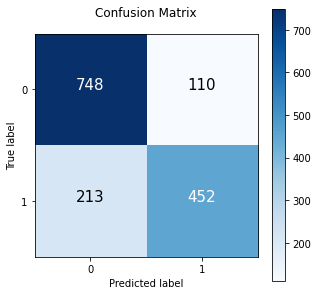

In [42]:
# Confusion Matrix
make_confusion_matrix(y_true = val_labels,
                      y_pred = model_1_preds,
                      figsize = (5,5))

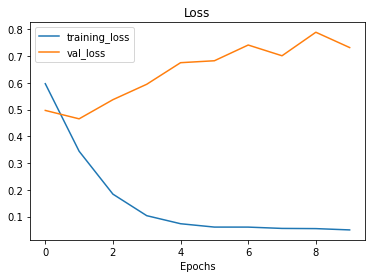

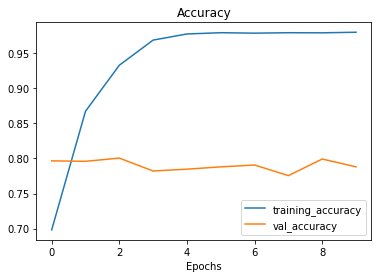

In [43]:
plot_loss_curves(model_1_history)

##Visualizing learned embeddings

In [44]:
# Get the unique words in the vocabulary
words_in_vocab = text_vectorizer.get_vocabulary()
top_5_words = words_in_vocab[:5] # most common tokens (notice the [UNK] token for "unknown" words)
bottom_5_words = words_in_vocab[-5:] # least common tokens
print(f"Number of words in vocab: {len(words_in_vocab)}")
print(f"Top 5 most common words: {top_5_words}") 
print(f"Bottom 5 least common words: {bottom_5_words}")

Number of words in vocab: 10000
Top 5 most common words: ['', '[UNK]', 'the', 'a', 'in']
Bottom 5 least common words: ['minded', 'mindblowing', 'milne', 'milledgeville', 'millcityio']


In [45]:
# Get the weight matrix of embedding layer 
# (these are the numerical patterns between the text in the training dataset the model has learned)
embed_weights = model_1.get_layer("embedding_1").get_weights()[0]
print(embed_weights.shape) # same size as vocab size and embedding_dim (each word is a embedding_dim size vector)

(10000, 512)


#Model 2: LSTM

In [46]:
# Set random seed and create embedding layer (new embedding layer for each model)
tf.random.set_seed(42)
from tensorflow.keras import layers
model_2_embedding = layers.Embedding(input_dim=max_vocab_length,
                                     output_dim=128,
                                     embeddings_initializer="uniform",
                                     input_length=max_length,
                                     name="embedding_2")


# Create LSTM model
inputs = layers.Input(shape=(1,), dtype="string")
x = text_vectorizer(inputs)
x = model_2_embedding(x)
print(x.shape)
x = layers.LSTM(64, return_sequences=True)(x) # return vector for each word in the Tweet (stack RNN cells as long as return_sequences=True)
x = layers.LSTM(64)(x) # return vector for whole sequence
print(x.shape)
x = layers.Dense(64, activation="relu")(x) # optional dense layer on top of output of LSTM cell
outputs = layers.Dense(1, activation="sigmoid")(x)
model_2 = tf.keras.Model(inputs, outputs, name="model_2_LSTM")

(None, 24, 128)
(None, 64)


In [47]:
# Compile model
model_2.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [48]:
model_2.summary()

Model: "model_2_LSTM"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization_1 (TextV  (None, 24)               0         
 ectorization)                                                   
                                                                 
 embedding_2 (Embedding)     (None, 24, 128)           1280000   
                                                                 
 lstm (LSTM)                 (None, 24, 64)            49408     
                                                                 
 lstm_1 (LSTM)               (None, 64)                33024     
                                                                 
 dense_2 (Dense)             (None, 64)                4160      
                                                      

In [49]:
# Fit model
model_2_history = model_2.fit(train_sentences,
                              train_labels,
                              epochs=10,
                              validation_data=(val_sentences, val_labels),
                              callbacks=[create_tensorboard_callback(SAVE_DIR, 
                                                                     "LSTM")])

Saving TensorBoard log files to: model_logs/LSTM/20230122-144530
Epoch 1/10
191/191 [==============================] - 8s 13ms/step - loss: 0.5184 - accuracy: 0.7322 - val_loss: 0.4541 - val_accuracy: 0.7958
Epoch 2/10
191/191 [==============================] - 2s 10ms/step - loss: 0.3080 - accuracy: 0.8745 - val_loss: 0.4781 - val_accuracy: 0.7768
Epoch 3/10
191/191 [==============================] - 2s 9ms/step - loss: 0.2086 - accuracy: 0.9282 - val_loss: 0.5919 - val_accuracy: 0.7892
Epoch 4/10
191/191 [==============================] - 2s 10ms/step - loss: 0.1387 - accuracy: 0.9522 - val_loss: 0.8615 - val_accuracy: 0.7584
Epoch 5/10
191/191 [==============================] - 2s 9ms/step - loss: 0.0940 - accuracy: 0.9616 - val_loss: 0.8602 - val_accuracy: 0.7859
Epoch 6/10
191/191 [==============================] - 2s 10ms/step - loss: 0.0880 - accuracy: 0.9665 - val_loss: 0.9549 - val_accuracy: 0.7617
Epoch 7/10
191/191 [==============================] - 2s 10ms/step - loss: 0.07

In [50]:
# Make predictions on the validation dataset
model_2_pred_probs = model_2.predict(val_sentences)
model_2_pred_probs.shape, model_2_pred_probs[:10] # view the first 10

48/48 [==============================] - 1s 4ms/step


((1523, 1), array([[0.99586725],
        [0.6729086 ],
        [0.99899226],
        [0.00954538],
        [0.02049964],
        [0.998733  ],
        [0.9957808 ],
        [0.9986638 ],
        [0.9984737 ],
        [0.26639512]], dtype=float32))

In [51]:
# Round out predictions and reduce to 1-dimensional array
model_2_preds = tf.squeeze(tf.round(model_2_pred_probs))
model_2_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([1., 1., 1., 0., 0., 1., 1., 1., 1., 0.], dtype=float32)>

In [52]:
# Calculate LSTM model results
model_2_results = calculate_results(y_true=val_labels,
                                    y_pred=model_2_preds)
model_2_results

{'accuracy': 0.7806959947472094,
 'precision': 0.7807998350486558,
 'recall': 0.7806959947472094,
 'f1': 0.778632118326057}

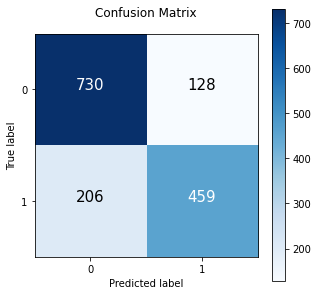

In [53]:
# Confusion Matrix
make_confusion_matrix(y_true = val_labels,
                      y_pred = model_2_preds,
                      figsize = (5,5))

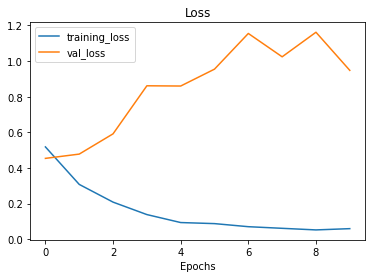

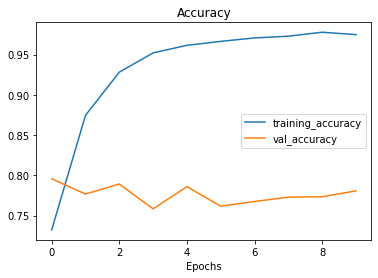

In [54]:
plot_loss_curves(model_2_history)

#Model 3: GRU

In [55]:
# Set random seed and create embedding layer (new embedding layer for each model)
tf.random.set_seed(42)
from tensorflow.keras import layers
model_3_embedding = layers.Embedding(input_dim=max_vocab_length,
                                     output_dim=256,
                                     embeddings_initializer="uniform",
                                     input_length=max_length,
                                     name="embedding_3")

# Build an RNN using the GRU cell
inputs = layers.Input(shape=(1,), dtype="string")
x = text_vectorizer(inputs)
x = model_3_embedding(x)
x = layers.GRU(64, return_sequences=True)(x) # stacking recurrent cells requires return_sequences=True
x = layers.GRU(64)(x) 
x = layers.Dense(64, activation="relu")(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model_3 = tf.keras.Model(inputs, outputs, name="model_3_GRU")

In [56]:
# Compile GRU model
model_3.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [57]:
# Get a summary of the GRU model
model_3.summary()

Model: "model_3_GRU"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization_1 (TextV  (None, 24)               0         
 ectorization)                                                   
                                                                 
 embedding_3 (Embedding)     (None, 24, 256)           2560000   
                                                                 
 gru (GRU)                   (None, 24, 64)            61824     
                                                                 
 gru_1 (GRU)                 (None, 64)                24960     
                                                                 
 dense_4 (Dense)             (None, 64)                4160      
                                                       

In [58]:
# Fit model
model_3_history = model_3.fit(train_sentences,
                              train_labels,
                              epochs=10,
                              validation_data=(val_sentences, val_labels),
                              callbacks=[create_tensorboard_callback(SAVE_DIR, "GRU")])

Saving TensorBoard log files to: model_logs/GRU/20230122-144616
Epoch 1/10
191/191 [==============================] - 5s 13ms/step - loss: 0.6109 - accuracy: 0.6493 - val_loss: 0.4642 - val_accuracy: 0.7925
Epoch 2/10
191/191 [==============================] - 2s 9ms/step - loss: 0.3652 - accuracy: 0.8483 - val_loss: 0.4733 - val_accuracy: 0.7879
Epoch 3/10
191/191 [==============================] - 2s 10ms/step - loss: 0.2334 - accuracy: 0.9149 - val_loss: 0.5602 - val_accuracy: 0.7905
Epoch 4/10
191/191 [==============================] - 2s 9ms/step - loss: 0.1508 - accuracy: 0.9475 - val_loss: 0.6856 - val_accuracy: 0.7682
Epoch 5/10
191/191 [==============================] - 2s 9ms/step - loss: 0.0957 - accuracy: 0.9686 - val_loss: 0.7243 - val_accuracy: 0.7827
Epoch 6/10
191/191 [==============================] - 2s 9ms/step - loss: 0.0673 - accuracy: 0.9736 - val_loss: 1.0084 - val_accuracy: 0.7741
Epoch 7/10
191/191 [==============================] - 3s 14ms/step - loss: 0.0517 

In [59]:
# Make predictions on the validation data
model_3_pred_probs = model_3.predict(val_sentences)
model_3_pred_probs.shape, model_3_pred_probs[:10]

48/48 [==============================] - 1s 3ms/step


((1523, 1), array([[7.8475314e-01],
        [9.9817407e-01],
        [9.9986255e-01],
        [4.9972553e-03],
        [4.5985240e-04],
        [9.9982351e-01],
        [9.9991775e-01],
        [9.9976701e-01],
        [9.9934787e-01],
        [3.6481878e-01]], dtype=float32))

In [60]:
# Convert prediction probabilities to prediction classes
model_3_preds = tf.squeeze(tf.round(model_3_pred_probs))
model_3_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([1., 1., 1., 0., 0., 1., 1., 1., 1., 0.], dtype=float32)>

In [61]:
# Calcuate model_3 results
model_3_results = calculate_results(y_true=val_labels, 
                                    y_pred=model_3_preds)
model_3_results

{'accuracy': 0.7754432042022325,
 'precision': 0.7751403762990469,
 'recall': 0.7754432042022325,
 'f1': 0.7736061245302526}

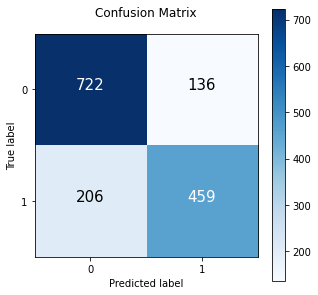

In [62]:
# Confusion Matrix
make_confusion_matrix(y_true = val_labels,
                      y_pred = model_3_preds,
                      figsize = (5,5))

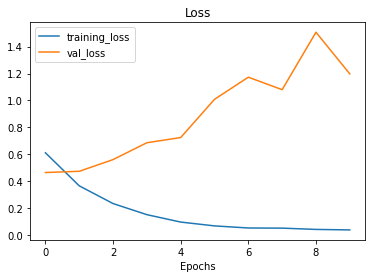

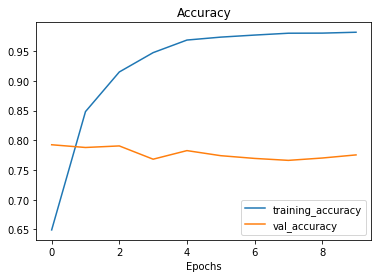

In [63]:
plot_loss_curves(model_3_history)

#Model 4: Bidirectonal RNN model

In [64]:
# Set random seed and create embedding layer (new embedding layer for each model)
tf.random.set_seed(42)
from tensorflow.keras import layers
model_4_embedding = layers.Embedding(input_dim=max_vocab_length,
                                     output_dim=128,
                                     embeddings_initializer="uniform",
                                     input_length=max_length,
                                     name="embedding_4")

# Build a Bidirectional RNN in TensorFlow
inputs = layers.Input(shape=(1,), dtype="string")
x = text_vectorizer(inputs)
x = model_4_embedding(x)
x = layers.Bidirectional(layers.LSTM(128, return_sequences=True))(x) # stacking RNN layers requires return_sequences=True
x = layers.Bidirectional(layers.LSTM(128))(x) # bidirectional goes both ways so has double the parameters of a regular LSTM layer
x = layers.Dense(128, activation = 'relu')(x)
x = layers.Dense(64, activation = 'relu')(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model_4 = tf.keras.Model(inputs, outputs, name="model_4_Bidirectional")

In [65]:
# Compile
model_4.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [66]:
# Get a summary of our bidirectional model
model_4.summary()

Model: "model_4_Bidirectional"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization_1 (TextV  (None, 24)               0         
 ectorization)                                                   
                                                                 
 embedding_4 (Embedding)     (None, 24, 128)           1280000   
                                                                 
 bidirectional (Bidirectiona  (None, 24, 256)          263168    
 l)                                                              
                                                                 
 bidirectional_1 (Bidirectio  (None, 256)              394240    
 nal)                                                            
                                             

In [67]:
# Fit the model (takes longer because of the bidirectional layers)
model_4_history = model_4.fit(train_sentences,
                              train_labels,
                              epochs=10,
                              validation_data=(val_sentences, val_labels),
                              callbacks=[create_tensorboard_callback(SAVE_DIR, "bidirectional_RNN")])

Saving TensorBoard log files to: model_logs/bidirectional_RNN/20230122-144641
Epoch 1/10
191/191 [==============================] - 10s 25ms/step - loss: 0.5131 - accuracy: 0.7437 - val_loss: 0.4563 - val_accuracy: 0.7991
Epoch 2/10
191/191 [==============================] - 3s 16ms/step - loss: 0.2988 - accuracy: 0.8773 - val_loss: 0.4910 - val_accuracy: 0.7846
Epoch 3/10
191/191 [==============================] - 3s 16ms/step - loss: 0.1951 - accuracy: 0.9320 - val_loss: 0.6574 - val_accuracy: 0.7800
Epoch 4/10
191/191 [==============================] - 3s 16ms/step - loss: 0.1269 - accuracy: 0.9563 - val_loss: 0.6756 - val_accuracy: 0.7748
Epoch 5/10
191/191 [==============================] - 3s 16ms/step - loss: 0.0883 - accuracy: 0.9658 - val_loss: 0.8378 - val_accuracy: 0.7781
Epoch 6/10
191/191 [==============================] - 3s 16ms/step - loss: 0.0660 - accuracy: 0.9744 - val_loss: 1.0494 - val_accuracy: 0.7735
Epoch 7/10
191/191 [==============================] - 3s 16ms/s

In [68]:
# Make predictions with bidirectional RNN on the validation data
model_4_pred_probs = model_4.predict(val_sentences)
model_4_pred_probs[:10]

48/48 [==============================] - 2s 6ms/step


array([[0.06369489],
       [0.75317895],
       [0.9999999 ],
       [0.07093649],
       [0.00192765],
       [0.9999999 ],
       [0.9999567 ],
       [1.        ],
       [0.999941  ],
       [0.00379347]], dtype=float32)

In [69]:
# Convert prediction probabilities to labels
model_4_preds = tf.squeeze(tf.round(model_4_pred_probs))
model_4_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 1., 1., 0., 0., 1., 1., 1., 1., 0.], dtype=float32)>

In [70]:
# Calculate bidirectional RNN model results
model_4_results = calculate_results(val_labels, model_4_preds)
model_4_results

{'accuracy': 0.7741300065659882,
 'precision': 0.7799595061278944,
 'recall': 0.7741300065659882,
 'f1': 0.7687473203924209}

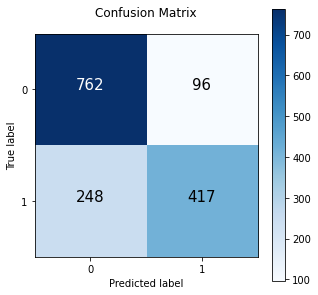

In [71]:
# Confusion Matrix
make_confusion_matrix(y_true = val_labels,
                      y_pred = model_4_preds,
                      figsize = (5,5))

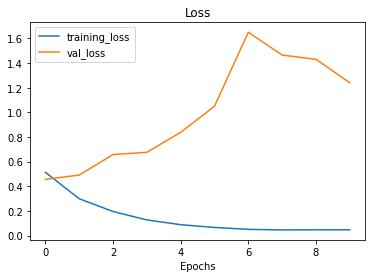

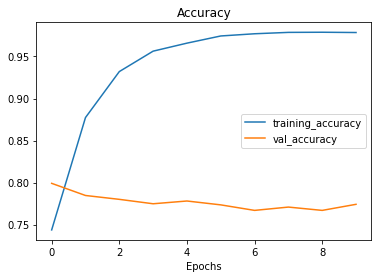

In [72]:
plot_loss_curves(model_4_history)

#Model 5: Conv1D - Convolutional Neural Networks for Text

In [73]:
# Test out the embedding, 1D convolutional and max pooling
embedding_test = embedding(text_vectorizer(["this is a test sentence"])) # turn target sentence into embedding
conv_1d = layers.Conv1D(filters=32, kernel_size=5, activation="relu") # convolve over target sequence 5 words at a time
conv_1d_output = conv_1d(embedding_test) # pass embedding through 1D convolutional layer
max_pool = layers.GlobalMaxPool1D() 
max_pool_output = max_pool(conv_1d_output) # get the most important features
embedding_test.shape, conv_1d_output.shape, max_pool_output.shape

(TensorShape([1, 24, 512]), TensorShape([1, 20, 32]), TensorShape([1, 32]))

In [74]:
# See the outputs of each layer
embedding_test[:1][0][0][:5], conv_1d_output[:1][0][0][:5], max_pool_output[:1][0][:5]

(<tf.Tensor: shape=(5,), dtype=float32, numpy=
 array([ 0.07057764, -0.0221996 , -0.06033932, -0.04142897, -0.02273828],
       dtype=float32)>, <tf.Tensor: shape=(5,), dtype=float32, numpy=
 array([0.        , 0.05923587, 0.03254502, 0.05403923, 0.        ],
       dtype=float32)>, <tf.Tensor: shape=(5,), dtype=float32, numpy=
 array([0.06825937, 0.17520414, 0.04813319, 0.05403923, 0.        ],
       dtype=float32)>)

In [75]:
# Set random seed and create embedding layer (new embedding layer for each model)
tf.random.set_seed(42)
from tensorflow.keras import layers
model_5_embedding = layers.Embedding(input_dim=max_vocab_length,
                                     output_dim=128,
                                     embeddings_initializer="uniform",
                                     input_length=max_length,
                                     name="embedding_5")

# Create 1-dimensional convolutional layer to model sequences
from tensorflow.keras import layers
inputs = layers.Input(shape=(1,), dtype="string")
x = text_vectorizer(inputs)
x = model_5_embedding(x)
x = layers.Conv1D(filters=128, kernel_size=5, activation="relu")(x)
x = layers.GlobalMaxPool1D()(x)
x = layers.Dense(64, activation="relu")(x)
x = layers.Dense(32, activation="relu")(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model_5 = tf.keras.Model(inputs, outputs, name="model_5_Conv1D")

# Compile Conv1D model
model_5.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

# Get a summary of our 1D convolution model
model_5.summary()

Model: "model_5_Conv1D"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization_1 (TextV  (None, 24)               0         
 ectorization)                                                   
                                                                 
 embedding_5 (Embedding)     (None, 24, 128)           1280000   
                                                                 
 conv1d_1 (Conv1D)           (None, 20, 128)           82048     
                                                                 
 global_max_pooling1d_2 (Glo  (None, 128)              0         
 balMaxPooling1D)                                                
                                                                 
 dense_9 (Dense)             (None, 64)             

In [76]:
# Fit the model
model_5_history = model_5.fit(train_sentences,
                              train_labels,
                              epochs=10,
                              validation_data=(val_sentences, val_labels),
                              callbacks=[create_tensorboard_callback(SAVE_DIR, 
                                                                     "Conv1D")])

Saving TensorBoard log files to: model_logs/Conv1D/20230122-144732
Epoch 1/10
191/191 [==============================] - 3s 7ms/step - loss: 0.5447 - accuracy: 0.7164 - val_loss: 0.4574 - val_accuracy: 0.7879
Epoch 2/10
191/191 [==============================] - 1s 6ms/step - loss: 0.2937 - accuracy: 0.8831 - val_loss: 0.4930 - val_accuracy: 0.7800
Epoch 3/10
191/191 [==============================] - 1s 6ms/step - loss: 0.1438 - accuracy: 0.9560 - val_loss: 0.5835 - val_accuracy: 0.7899
Epoch 4/10
191/191 [==============================] - 1s 6ms/step - loss: 0.0931 - accuracy: 0.9752 - val_loss: 0.6316 - val_accuracy: 0.7715
Epoch 5/10
191/191 [==============================] - 1s 6ms/step - loss: 0.0693 - accuracy: 0.9803 - val_loss: 0.7303 - val_accuracy: 0.7814
Epoch 6/10
191/191 [==============================] - 1s 6ms/step - loss: 0.0550 - accuracy: 0.9834 - val_loss: 0.6893 - val_accuracy: 0.7735
Epoch 7/10
191/191 [==============================] - 1s 6ms/step - loss: 0.0418 

In [77]:
# Make predictions with model_5
model_5_pred_probs = model_5.predict(val_sentences)
model_5_pred_probs[:10]

48/48 [==============================] - 0s 2ms/step


array([[9.7861552e-01],
       [9.9546248e-01],
       [9.9998987e-01],
       [1.2950889e-04],
       [9.4056733e-02],
       [9.9994767e-01],
       [9.9975842e-01],
       [9.9997425e-01],
       [9.9995768e-01],
       [1.7707713e-01]], dtype=float32)

In [78]:
# Convert model_5 prediction probabilities to labels
model_5_preds = tf.squeeze(tf.round(model_5_pred_probs))
model_5_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([1., 1., 1., 0., 0., 1., 1., 1., 1., 0.], dtype=float32)>

In [79]:
# Calculate model_5 evaluation metrics 
model_5_results = calculate_results(y_true=val_labels, 
                                    y_pred=model_5_preds)
model_5_results

{'accuracy': 0.7642810242941562,
 'precision': 0.7643213408572419,
 'recall': 0.7642810242941562,
 'f1': 0.7643008511383649}

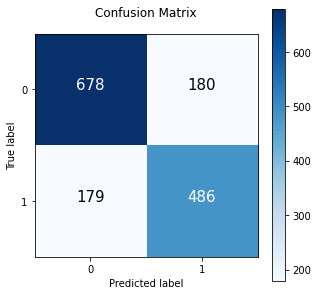

In [80]:
# Confusion Matrix
make_confusion_matrix(y_true = val_labels,
                      y_pred = model_5_preds,
                      figsize = (5,5))

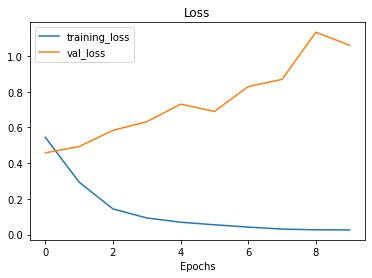

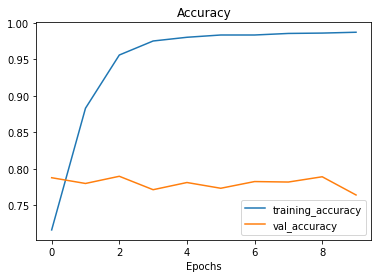

In [81]:
plot_loss_curves(model_5_history)

#Model 6: TensorFlow Hub Pretrained Sentence Encoder

In [82]:
# Example of pretrained embedding with universal sentence encoder - https://tfhub.dev/google/universal-sentence-encoder/4
import tensorflow_hub as hub
embed = hub.load("https://tfhub.dev/google/universal-sentence-encoder/4") # load Universal Sentence Encoder
embed_samples = embed([sample_sentence,
                      "When you call the universal sentence encoder on a sentence, it turns it into numbers."])

print(embed_samples[0][:50])

tf.Tensor(
[-0.01543392  0.04418021 -0.00018905 -0.00092176  0.0047661  -0.00218352
 -0.03158046 -0.03839371  0.04538786  0.0130949  -0.0195525   0.02157117
  0.01740765  0.06280868  0.01011858 -0.06294926 -0.03036817 -0.08452946
 -0.03235388 -0.02291678 -0.02258634 -0.06310236  0.04596439  0.03671975
 -0.030437   -0.05042022 -0.00914995 -0.05756651  0.02258523 -0.04189885
 -0.04259583 -0.03958908  0.02678671 -0.07027774 -0.02199684 -0.00229655
 -0.01049679  0.07795434 -0.05125295  0.01910721 -0.06892136  0.03080141
 -0.00780563  0.06751702 -0.07831968  0.07357198  0.00914911 -0.01805634
 -0.0033897  -0.03436421], shape=(50,), dtype=float32)


In [83]:
# Each sentence has been encoded into a 512 dimension vector
embed_samples[0].shape

TensorShape([512])

In [84]:
# We can use this encoding layer in place of our text_vectorizer and embedding layer
sentence_encoder_layer = hub.KerasLayer("https://tfhub.dev/google/universal-sentence-encoder/4",
                                        input_shape=[], # shape of inputs coming to our model 
                                        dtype=tf.string, # data type of inputs coming to the USE layer
                                        trainable=False, # keep the pretrained weights (we'll create a feature extractor)
                                        name="USE") 

In [85]:
# Create model using the Sequential API
model_6 = tf.keras.Sequential([
  sentence_encoder_layer, # take in sentences and then encode them into an embedding
  layers.Dense(64, activation="relu"),
  layers.Dense(1, activation="sigmoid")
], name="model_6_USE")

# Compile model
model_6.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

model_6.summary()

Model: "model_6_USE"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 USE (KerasLayer)            (None, 512)               256797824 
                                                                 
 dense_12 (Dense)            (None, 64)                32832     
                                                                 
 dense_13 (Dense)            (None, 1)                 65        
                                                                 
Total params: 256,830,721
Trainable params: 32,897
Non-trainable params: 256,797,824
_________________________________________________________________


In [86]:
# Train a classifier on top of pretrained embeddings
model_6_history = model_6.fit(train_sentences,
                              train_labels,
                              epochs=10,
                              validation_data=(val_sentences, val_labels),
                              callbacks=[create_tensorboard_callback(SAVE_DIR, 
                                                                     "tf_hub_sentence_encoder")])

Saving TensorBoard log files to: model_logs/tf_hub_sentence_encoder/20230122-144836
Epoch 1/10
191/191 [==============================] - 5s 15ms/step - loss: 0.5136 - accuracy: 0.7742 - val_loss: 0.4509 - val_accuracy: 0.7971
Epoch 2/10
191/191 [==============================] - 3s 13ms/step - loss: 0.4142 - accuracy: 0.8136 - val_loss: 0.4413 - val_accuracy: 0.7984
Epoch 3/10
191/191 [==============================] - 3s 13ms/step - loss: 0.3982 - accuracy: 0.8215 - val_loss: 0.4436 - val_accuracy: 0.8024
Epoch 4/10
191/191 [==============================] - 2s 13ms/step - loss: 0.3890 - accuracy: 0.8282 - val_loss: 0.4396 - val_accuracy: 0.8050
Epoch 5/10
191/191 [==============================] - 2s 13ms/step - loss: 0.3829 - accuracy: 0.8292 - val_loss: 0.4389 - val_accuracy: 0.8089
Epoch 6/10
191/191 [==============================] - 2s 13ms/step - loss: 0.3763 - accuracy: 0.8332 - val_loss: 0.4383 - val_accuracy: 0.8037
Epoch 7/10
191/191 [==============================] - 3s 1

In [87]:
# Make predictions with USE TF Hub model
model_6_pred_probs = model_6.predict(val_sentences)
model_6_pred_probs[:10]

48/48 [==============================] - 1s 9ms/step


array([[0.19732971],
       [0.82359415],
       [0.9952442 ],
       [0.14045496],
       [0.7077096 ],
       [0.76131606],
       [0.9883294 ],
       [0.991748  ],
       [0.95424074],
       [0.0568521 ]], dtype=float32)

In [88]:
# Convert prediction probabilities to labels
model_6_preds = tf.squeeze(tf.round(model_6_pred_probs))
model_6_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 1., 1., 0., 1., 1., 1., 1., 1., 0.], dtype=float32)>

In [89]:
# Calculate model 6 performance metrics
model_6_results = calculate_results(val_labels, model_6_preds)
model_6_results

{'accuracy': 0.8115561391989494,
 'precision': 0.8124809921205965,
 'recall': 0.8115561391989494,
 'f1': 0.8097528880145408}

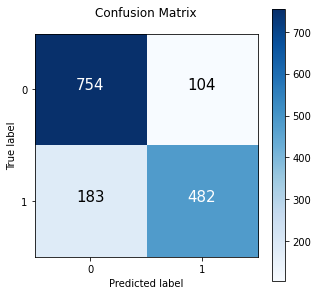

In [90]:
# Confusion Matrix
make_confusion_matrix(y_true = val_labels,
                      y_pred = model_6_preds,
                      figsize = (5,5))

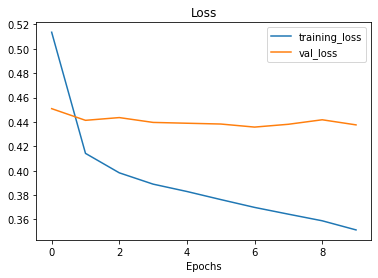

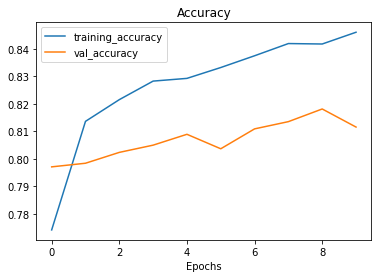

In [91]:
plot_loss_curves(model_6_history)

# Model 7

In [92]:
# Create model using the Sequential API
model_7 = tf.keras.Sequential([
  sentence_encoder_layer, # take in sentences and then encode them into an embedding
  layers.Dense(128, activation="relu"),
  layers.Dense(64, activation="relu"),
  layers.Dense(32, activation="relu"),
  layers.Dense(1, activation="sigmoid")
], name="model_7_USE_Dense")

# Compile model
model_7.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

model_7.summary()

Model: "model_7_USE_Dense"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 USE (KerasLayer)            (None, 512)               256797824 
                                                                 
 dense_14 (Dense)            (None, 128)               65664     
                                                                 
 dense_15 (Dense)            (None, 64)                8256      
                                                                 
 dense_16 (Dense)            (None, 32)                2080      
                                                                 
 dense_17 (Dense)            (None, 1)                 33        
                                                                 
Total params: 256,873,857
Trainable params: 76,033
Non-trainable params: 256,797,824
_________________________________________________________________


In [93]:
# Train a classifier on top of pretrained embeddings
model_7_history = model_7.fit(train_sentences,
                              train_labels,
                              epochs=10,
                              validation_data=(val_sentences, val_labels),
                              callbacks=[create_tensorboard_callback(SAVE_DIR, 
                                                                     "tf_hub_sentence_encoder")])

Saving TensorBoard log files to: model_logs/tf_hub_sentence_encoder/20230122-144921
Epoch 1/10
191/191 [==============================] - 4s 16ms/step - loss: 0.4779 - accuracy: 0.7785 - val_loss: 0.4361 - val_accuracy: 0.8063
Epoch 2/10
191/191 [==============================] - 3s 14ms/step - loss: 0.3886 - accuracy: 0.8315 - val_loss: 0.4284 - val_accuracy: 0.8168
Epoch 3/10
191/191 [==============================] - 3s 14ms/step - loss: 0.3550 - accuracy: 0.8499 - val_loss: 0.4405 - val_accuracy: 0.8148
Epoch 4/10
191/191 [==============================] - 3s 14ms/step - loss: 0.3097 - accuracy: 0.8719 - val_loss: 0.4501 - val_accuracy: 0.8155
Epoch 5/10
191/191 [==============================] - 3s 16ms/step - loss: 0.2560 - accuracy: 0.8989 - val_loss: 0.4881 - val_accuracy: 0.8043
Epoch 6/10
191/191 [==============================] - 3s 14ms/step - loss: 0.1930 - accuracy: 0.9281 - val_loss: 0.5631 - val_accuracy: 0.8056
Epoch 7/10
191/191 [==============================] - 3s 1

In [94]:
# Make predictions with the model trained on 10% of the data
model_7_pred_probs = model_7.predict(val_sentences)
model_7_pred_probs[:10]

48/48 [==============================] - 1s 9ms/step


array([[2.3227300e-04],
       [9.9246335e-01],
       [9.9999964e-01],
       [7.8114085e-03],
       [1.8048106e-01],
       [9.7970378e-01],
       [9.9985504e-01],
       [9.9999642e-01],
       [9.9886668e-01],
       [1.2209684e-03]], dtype=float32)

In [95]:
# Convert prediction probabilities to labels
model_7_preds = tf.squeeze(tf.round(model_7_pred_probs))
model_7_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 1., 1., 0., 0., 1., 1., 1., 1., 0.], dtype=float32)>

In [96]:
# Calculate model results
model_7_results = calculate_results(val_labels, model_7_preds)
model_7_results

{'accuracy': 0.7971109652002626,
 'precision': 0.7971506507616587,
 'recall': 0.7971109652002626,
 'f1': 0.7955414987622836}

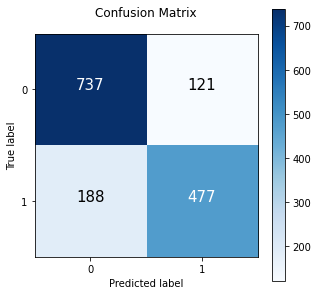

In [97]:
# Confusion Matrix
make_confusion_matrix(y_true = val_labels,
                      y_pred = model_7_preds,
                      figsize = (5,5))

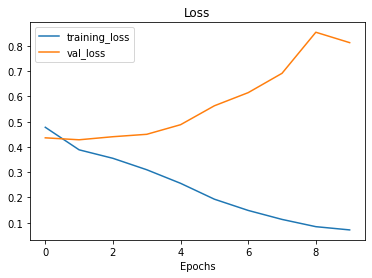

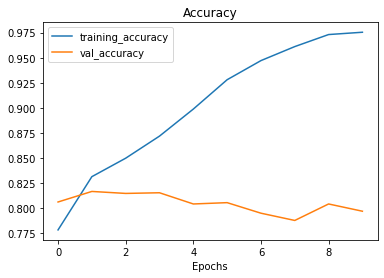

In [98]:
plot_loss_curves(model_7_history)

#Comparing the performance of each of our models

In [99]:
# Combine model results into a DataFrame
all_model_results = pd.DataFrame({"baseline": baseline_results,
                                  "simple_dense": model_1_results,
                                  "lstm": model_2_results,
                                  "gru": model_3_results,
                                  "bidirectional": model_4_results,
                                  "conv1d": model_5_results,
                                  "tf_hub_sentence_encoder": model_6_results,
                                  "tf_hub_sentence_encoder_4_Dense": model_7_results})
all_model_results = all_model_results.transpose()
all_model_results

,accuracy,precision,recall,f1
baseline,0.799081,0.814636,0.799081,0.792016
simple_dense,0.787919,0.789671,0.787919,0.785022
lstm,0.780696,0.780800,0.780696,0.778632
gru,0.775443,0.775140,0.775443,0.773606
bidirectional,0.774130,0.779960,0.774130,0.768747
conv1d,0.764281,0.764321,0.764281,0.764301
tf_hub_sentence_encoder,0.811556,0.812481,0.811556,0.809753
tf_hub_sentence_encoder_4_Dense,0.797111,0.797151,0.797111,0.795541


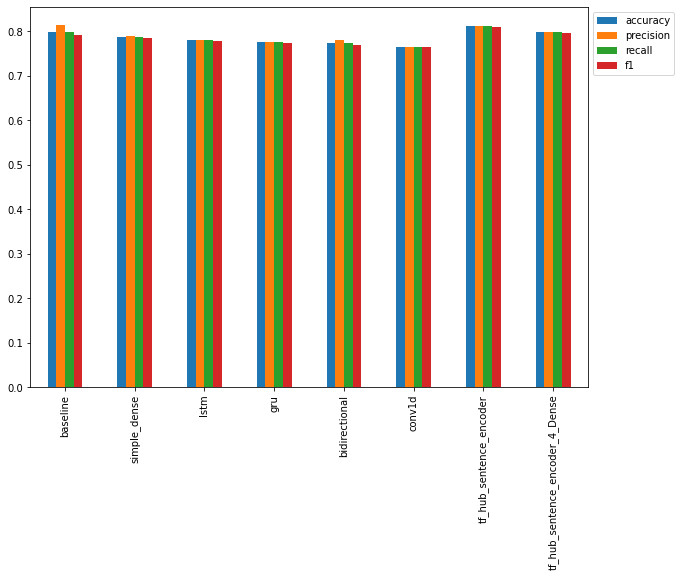

In [100]:
# Plot and compare all of the model results
all_model_results.plot(kind="bar", figsize=(10, 7)).legend(bbox_to_anchor=(1.0, 1.0));

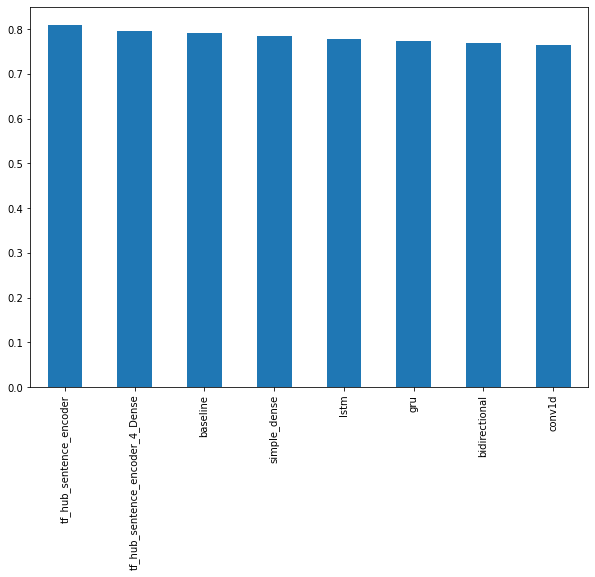

In [101]:
# Sort model results by f1-score
all_model_results.sort_values("f1", ascending=False)["f1"].plot(kind="bar", figsize=(10, 7));

#Combining our models (model ensembling/stacking)

In [102]:
# Get mean pred probs for 3 models
baseline_pred_probs = np.max(model_0.predict_proba(val_sentences), axis=1) # get the prediction probabilities from baseline model
combined_pred_probs = baseline_pred_probs + tf.squeeze(model_2_pred_probs, axis=1) + tf.squeeze(model_6_pred_probs)
combined_preds = tf.round(combined_pred_probs/3) # average and round the prediction probabilities to get prediction classes
combined_preds[:20]

<tf.Tensor: shape=(20,), dtype=float32, numpy=
array([1., 1., 1., 0., 0., 1., 1., 1., 1., 0., 0., 0., 1., 1., 0., 0., 0.,
       0., 0., 1.], dtype=float32)>

In [103]:
# Calculate results from averaging the prediction probabilities
ensemble_results = calculate_results(val_labels, combined_preds)
ensemble_results

{'accuracy': 0.7839789888378201,
 'precision': 0.7834608311213659,
 'recall': 0.7839789888378201,
 'f1': 0.7835964431721443}

In [104]:
# Add our combined model's results to the results DataFrame
all_model_results.loc["ensemble_results"] = ensemble_results

In [105]:
all_model_results

,accuracy,precision,recall,f1
baseline,0.799081,0.814636,0.799081,0.792016
simple_dense,0.787919,0.789671,0.787919,0.785022
lstm,0.780696,0.780800,0.780696,0.778632
gru,0.775443,0.775140,0.775443,0.773606
bidirectional,0.774130,0.779960,0.774130,0.768747
conv1d,0.764281,0.764321,0.764281,0.764301
tf_hub_sentence_encoder,0.811556,0.812481,0.811556,0.809753
tf_hub_sentence_encoder_4_Dense,0.797111,0.797151,0.797111,0.795541
ensemble_results,0.783979,0.783461,0.783979,0.783596


#Saving and loading a trained model

In [106]:
# Save TF Hub Sentence Encoder model to HDF5 format
model_6.save("model_6.h5")

In [107]:
# Load model with custom Hub Layer (required with HDF5 format)
loaded_model_6 = tf.keras.models.load_model("model_6.h5", 
                                            custom_objects={"KerasLayer": hub.KerasLayer})

#Finding the most wrong examples

In [108]:
# Create dataframe with validation sentences and best performing model predictions
val_df = pd.DataFrame({"text": val_sentences,
                       "target": val_labels,
                       "pred": model_6_preds,
                       "pred_prob": tf.squeeze(model_6_pred_probs)})
val_df.head()

,text,target,pred,pred_prob
0,DFR EP016 Monthly Meltdown - On Dnbheaven 2015...,0,0.0,0.197330
1,FedEx no longer to transport bioterror germs i...,0,1.0,0.823594
2,Gunmen kill four in El Salvador bus attack: Su...,1,1.0,0.995244
3,@camilacabello97 Internally and externally scr...,1,0.0,0.140455
4,Radiation emergency #preparedness starts with ...,1,1.0,0.707710


In [109]:
# Find the wrong predictions and sort by prediction probabilities
most_wrong = val_df[val_df["target"] != val_df["pred"]].sort_values("pred_prob", ascending=False)
most_wrong[:10]

,text,target,pred,pred_prob
881,@adorableappple No reported flooding po in the...,0,1.0,0.991746
1307,We should all have a fire safety plan. RT @Mat...,0,1.0,0.974399
1502,Two Jewish Terrorists Charged In Historic-Chur...,0,1.0,0.969479
846,Mourning notices for stabbing arson victims st...,0,1.0,0.968211
769,Weapons stolen from National Guard Armory in N...,0,1.0,0.934333
814,the MOFO in DC will leave our military unarmed...,0,1.0,0.934000
628,@noah_anyname That's where the concentration c...,0,1.0,0.919182
813,Aug. 5: The Fort Calhoun Nuclear Station is at...,0,1.0,0.912797
759,FedEx will no longer transport bioterror patho...,0,1.0,0.912496
31,? High Skies - Burning Buildings ? http://t.co...,0,1.0,0.909935


In [110]:
# Check the false positives (model predicted 1 when should've been 0)
for row in most_wrong[:5].itertuples(): # loop through the top 5 rows (change the index to view different rows)
  _, text, target, pred, prob = row
  print(f"Target: {target}, Pred: {int(pred)}, Prob: {prob}")
  print(f"Text:\n{text}\n")
  print("----\n")

Target: 0, Pred: 1, Prob: 0.9917457699775696
Text:
@adorableappple No reported flooding po in the area. Ten-4. #mmda

----

Target: 0, Pred: 1, Prob: 0.9743990302085876
Text:
We should all have a fire safety plan. RT @Matt_Kroschel: MOCK WILDFIRE near #Vail as agencies prepare for the worst. http://t.co/SWwyLRk0fv

----

Target: 0, Pred: 1, Prob: 0.9694794416427612
Text:
Two Jewish Terrorists Charged In Historic-Church Arson | The Ugly Truth http://t.co/iEksNFSbY7 http://t.co/VWCf3slkrW

----

Target: 0, Pred: 1, Prob: 0.9682111740112305
Text:
Mourning notices for stabbing arson victims stir Û÷politics of griefÛª in Israel: Posters for Shira Banki and A... http://t.co/3GZ5zQQTHe

----

Target: 0, Pred: 1, Prob: 0.9343327879905701
Text:
Weapons stolen from National Guard Armory in New Albany still missing #Gunsense http://t.co/lKNU8902JE

----



In [111]:
# Check the most wrong false negatives (model predicted 0 when should've predict 1)
for row in most_wrong[-5:].itertuples():
  _, text, target, pred, prob = row
  print(f"Target: {target}, Pred: {int(pred)}, Prob: {prob}")
  print(f"Text:\n{text}\n")
  print("----\n")

Target: 1, Pred: 0, Prob: 0.029391104355454445
Text:
Why are you deluged with low self-image? Take the quiz: http://t.co/XsPqdOrIqj http://t.co/CQYvFR4UCy

----

Target: 1, Pred: 0, Prob: 0.02806834876537323
Text:
'I did another one I did another one. You still ain't done shit about the other one.' Nigga body bagging Meek.

----

Target: 1, Pred: 0, Prob: 0.024453576654195786
Text:
You can never escape me. Bullets don't harm me. Nothing harms me. But I know pain. I know pain. Sometimes I share it. With someone like you.

----

Target: 1, Pred: 0, Prob: 0.022648142650723457
Text:
the sunset boys wreck my bed   original 1979 usa gimp label  vinyl 7' 45  newave http://t.co/X0QLgwoyMT http://t.co/hQNx8qMeG3

----

Target: 1, Pred: 0, Prob: 0.02125450223684311
Text:
I get to smoke my shit in peace

----



#Making predictions on the test dataset

In [112]:
# Making predictions on the test dataset
test_sentences = test_df["text"].to_list()
test_samples = random.sample(test_sentences, 5)
for test_sample in test_samples:
  pred_prob = tf.squeeze(model_6.predict([test_sample])) # has to be list
  pred = tf.round(pred_prob)
  print(f"Pred: {int(pred)}, Prob: {pred_prob}")
  print(f"Text:\n{test_sample}\n")
  print("----\n")

1/1 [==============================] - 0s 30ms/step
Pred: 0, Prob: 0.34569281339645386
Text:
Photo bombed by a princess http://t.co/i4PthsuYQ9

----

1/1 [==============================] - 0s 30ms/step
Pred: 0, Prob: 0.08786353468894958
Text:
i survived what you tried to destroy you're not a man just a boy

----

1/1 [==============================] - 0s 31ms/step
Pred: 0, Prob: 0.13164550065994263
Text:
@cameron13131313 @OtooleDalton @averywelch23 @otoole1055 first of all you can't 'hit stick' shit.. Second I'm body bagging you on sight ??????

----

1/1 [==============================] - 0s 28ms/step
Pred: 0, Prob: 0.028631236404180527
Text:
Wow bro blew up quick. Believe it or not he's this funny and clever in person at all times. You be like 'where... http://t.co/djIHN95YnB

----

1/1 [==============================] - 0s 28ms/step
Pred: 0, Prob: 0.12477778643369675
Text:
Night 3 of insomnia this whole stop blazing shit is real

----



# Predicting on Tweets from the wild

In [113]:
# Turn Tweet into string
sample_tweet_2 = "52 are missing following a mudslide from southern China"
sample_tweet_3 = "I have flooding due to a burst pipe in the shower"

In [114]:
def predict_on_sentence(model, sentence):
  """
  Uses model to make a prediction on sentence.

  Returns the sentence, the predicted label and the prediction probability.
  """
  pred_prob = model.predict([sentence])
  pred_label = tf.squeeze(tf.round(pred_prob)).numpy()
  print(f"Pred: {pred_label}", "(real disaster)" if pred_label > 0 else "(not real disaster)", f"Prob: {pred_prob[0][0]}")
  print(f"Text:\n{sentence}")

In [115]:
# Make a prediction on Tweet from the wild
predict_on_sentence(model=model_6, # use the USE model
                    sentence=sample_tweet_2)

1/1 [==============================] - 0s 33ms/step
Pred: 1.0 (real disaster) Prob: 0.9005313515663147
Text:
52 are missing following a mudslide from southern China


In [116]:
# Make a prediction on Tweet from the wild
predict_on_sentence(model=model_6, # use the USE model
                    sentence=sample_tweet_3)

1/1 [==============================] - 0s 41ms/step
Pred: 0.0 (not real disaster) Prob: 0.389048308134079
Text:
I have flooding due to a burst pipe in the shower


In [117]:
# Source - https://twitter.com/CNN/status/1617129983687655426
CNN_tweet_1 = "The activist -- 26-year-old Manuel Esteban Paez Terán -- was shot near a planned $90 million, 85-acre law enforcement training facility where opponents had camped out for months in an attempt to halt its construction."

# Source -https://twitter.com/CNN/status/1617107357808447489
CNN_tweet_2 = "A small plane made an emergency landing on Interstate 40 in Knoxville, Tennessee, managing not to strike any vehicles in the process, according to the Knoxville Police Department."

In [118]:
# Predict on diaster Tweet 1
predict_on_sentence(model=model_6, 
                    sentence=CNN_tweet_1)

1/1 [==============================] - 0s 29ms/step
Pred: 1.0 (real disaster) Prob: 0.8951565623283386
Text:
The activist -- 26-year-old Manuel Esteban Paez Terán -- was shot near a planned $90 million, 85-acre law enforcement training facility where opponents had camped out for months in an attempt to halt its construction.


In [119]:
# Predict on diaster Tweet 2
predict_on_sentence(model=model_6, 
                    sentence=CNN_tweet_2)

1/1 [==============================] - 0s 28ms/step
Pred: 1.0 (real disaster) Prob: 0.9454184174537659
Text:
A small plane made an emergency landing on Interstate 40 in Knoxville, Tennessee, managing not to strike any vehicles in the process, according to the Knoxville Police Department.


#The speed/score tradeoff

In [120]:
# Calculate the time of predictions
import time
def pred_timer(model, samples):
  """
  Times how long a model takes to make predictions on samples.
  
  Args:
  ----
  model = a trained model
  sample = a list of samples

  Returns:
  ----
  total_time = total elapsed time for model to make predictions on samples
  time_per_pred = time in seconds per single sample
  """
  start_time = time.perf_counter() # get start time
  model.predict(samples) # make predictions
  end_time = time.perf_counter() # get finish time
  total_time = end_time-start_time # calculate how long predictions took to make
  time_per_pred = total_time/len(val_sentences) # find prediction time per sample
  return total_time, time_per_pred

In [121]:
# Calculate TF Hub Sentence Encoder prediction times
model_6_total_pred_time, model_6_time_per_pred = pred_timer(model_6, val_sentences)
model_6_total_pred_time, model_6_time_per_pred

48/48 [==============================] - 0s 9ms/step


(0.6612231389999579, 0.0004341583315823755)

In [122]:
# Calculate Naive Bayes prediction times
baseline_total_pred_time, baseline_time_per_pred = pred_timer(model_0, val_sentences)
baseline_total_pred_time, baseline_time_per_pred

(0.03519619799999418, 2.3109782009188564e-05)

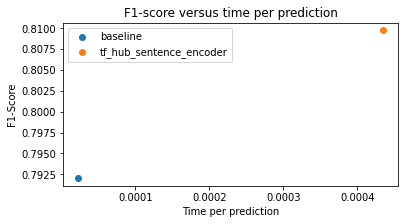

In [123]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6, 3))
plt.scatter(baseline_time_per_pred, baseline_results["f1"], label="baseline")
plt.scatter(model_6_time_per_pred, model_6_results["f1"], label="tf_hub_sentence_encoder")
plt.legend()
plt.title("F1-score versus time per prediction")
plt.xlabel("Time per prediction")
plt.ylabel("F1-Score");